In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

from hatespeech import HateSpeechClassifier

%matplotlib inline
%config IPCompleter.greedy=True

In [2]:
csf = HateSpeechClassifier()
X, y = csf.build()
tweets = csf.df.tweet
feats_names = csf.feature_names

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f073480cb00>]],
      dtype=object)

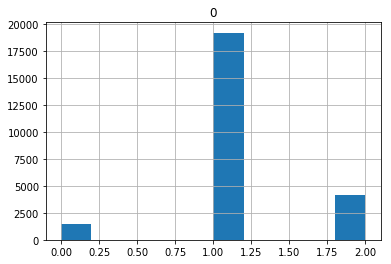

In [3]:
pd.DataFrame(y).hist()

In [4]:
X.shape, len(feats_names)

((24783, 11145), 11145)

In [5]:
data = pd.DataFrame(X, columns=feats_names)
data['class'] = y
data.head()

ab  abil  abl  abo  abort  abov  absolut  abt  abu  abus     ...      \
0  0.0   0.0  0.0  0.0    0.0   0.0      0.0  0.0  0.0   0.0     ...       
1  0.0   0.0  0.0  0.0    0.0   0.0      0.0  0.0  0.0   0.0     ...       
2  0.0   0.0  0.0  0.0    0.0   0.0      0.0  0.0  0.0   0.0     ...       
3  0.0   0.0  0.0  0.0    0.0   0.0      0.0  0.0  0.0   0.0     ...       
4  0.0   0.0  0.0  0.0    0.0   0.0      0.0  0.0  0.0   0.0     ...       

   num_words  num_unique_words  vader neg  vader pos  vader neu  \
0       25.0              23.0      0.000      0.120      0.880   
1       16.0              16.0      0.237      0.000      0.763   
2       20.0              18.0      0.538      0.000      0.462   
3        8.0               8.0      0.000      0.344      0.656   
4       26.0              23.0      0.109      0.229      0.662   

   vader compound  num_hashtags  num_mentions  num_urls  is_retweet  
0          0.4563           0.0           1.0       0.0         0.0  
1         -0.6876           0.0           1.0       0.0         0.0  
2         -0.9550           0.0           2.0       0.0         1.0  
3          0.5673           0.0           2.0       0.0         0.0  
4          0.6331           1.0           1.0       0.0         0.0  

[5 rows x 11145 columns]

In [6]:
def generate_meta_features(x, y, old_data, metric="minkowski"):
    neigh = KNeighborsClassifier(n_neighbors=30, n_jobs=10, metric=metric)
    neigh.fit(x, y)
    neighbors_dists, neighbors_inds = neigh.kneighbors(return_distance=True)
    
    size = len(neighbors_dists)
    meta_names = [
        'min_dist_0', 'min_dist_1', 'min_dist_2', 
        'max_dist_0', 'max_dist_1', 'max_dist_2', 
        'mean_dist_0', 'mean_dist_1','mean_dist_2', 
        'quantile_inf_0', 'quantile_inf_1', 'quantile_inf_2', 
        'quantile_sup_0', 'quantile_sup_1', 'quantile_sup_2',
        'count_neighbors_0', 'count_neighbors_1', 'count_neighbors_2',
        'count_max_neighbors_0', 'count_max_neighbors_1', 'count_max_neighbors_2'
    ]
    df_meta_features = pd.DataFrame(np.zeros((size, len(meta_names))), columns=meta_names)

    for i, (dist, ind) in enumerate(zip(neighbors_dists, neighbors_inds)):
        df_neighbors = old_data.loc[ind]

        df_dist = pd.DataFrame(dist, index=ind)

        df_neighbors_0 = df_neighbors[df_neighbors['class']==0]
        df_neighbors_1 = df_neighbors[df_neighbors['class']==1]
        df_neighbors_2 = df_neighbors[df_neighbors['class']==2]

        ind_0 = df_neighbors_0.index.values.tolist()
        ind_1 = df_neighbors_1.index.values.tolist()
        ind_2 = df_neighbors_2.index.values.tolist()

        values0 = df_dist.loc[ind_0].values
        values1 = df_dist.loc[ind_1].values
        values2 = df_dist.loc[ind_2].values

        if not df_neighbors_0.empty:
            df_meta_features.loc[i, 'min_dist_0'] = np.min(values0)
            df_meta_features.loc[i, 'max_dist_0'] = np.max(values0)
            df_meta_features.loc[i, 'mean_dist_0'] = np.mean(values0)

            quantile0 = np.quantile(values0, [0.25, 0.75])

            df_meta_features.loc[i, 'quantile_inf_0'] = quantile0[0]
            df_meta_features.loc[i, 'quantile_sup_0'] = quantile0[1]

            df_meta_features.loc[i, 'count_neighbors_0'] = len(values0)

            max_dist0 = np.max([len(k) for k in (values0, values1, values2)])
            df_meta_features.loc[i, 'count_max_neighbors_0'] = len(values0) / max_dist0

        if not df_neighbors_1.empty:
            df_meta_features.loc[i, 'min_dist_1'] = np.min(values1)
            df_meta_features.loc[i, 'max_dist_1'] = np.max(values1)
            df_meta_features.loc[i, 'mean_dist_1'] = np.mean(values1)

            quantile1 = np.quantile(values1, [0.25, 0.75])

            df_meta_features.loc[i, 'quantile_inf_1'] = quantile1[0]
            df_meta_features.loc[i, 'quantile_sup_1'] = quantile1[1]

            df_meta_features.loc[i, 'count_neighbors_1'] = len(values1)

            max_dist1 = np.max([len(k) for k in (values0, values1, values2)])
            df_meta_features.loc[i, 'count_max_neighbors_1'] = len(values1) / max_dist1

        if not df_neighbors_2.empty:
            df_meta_features.loc[i, 'min_dist_2'] = np.min(values2)
            df_meta_features.loc[i, 'max_dist_2'] = np.max(values2)
            df_meta_features.loc[i, 'mean_dist_2'] = np.mean(values2)

            quantile2 = np.quantile(values2, [0.25, 0.75])

            df_meta_features.loc[i, 'quantile_inf_2'] = quantile2[0]
            df_meta_features.loc[i, 'quantile_sup_2'] = quantile2[1]

            df_meta_features.loc[i, 'count_neighbors_2'] = len(values2)

            max_dist2 = np.max([len(k) for k in (values0, values1, values2)])
            df_meta_features.loc[i, 'count_max_neighbors_2'] = len(values2) / max_dist2
            
#     new_x = pd.DataFrame(x)
    new_data = pd.concat([x, df_meta_features], axis=1)
    print("Tamanho dos datasets x e new_data:")
    print(x.shape, new_data.shape)
    
    return new_data
    

In [7]:
def conf_matrix(matrix):
    matrix_proportions = np.zeros((3, 3))
    for i in range(0, 3):
        matrix_proportions[i, :] = matrix[i, :] / float(matrix[i, :].sum())
            
    return matrix_proportions

In [8]:
def run_tests(df_x, df_y, original_data, metric="minkowski"):
    select_model = SelectFromModel(
        LogisticRegression(class_weight='balanced', penalty='l1', C=0.01)
    )
    
    new_x = select_model.fit_transform(df_x, df_y)
    new_inxs = select_model.get_support(indices=True)
    new_x = pd.DataFrame(new_x, columns=original_data.columns.values[new_inxs])
    
    new_x = generate_meta_features(new_x, df_y, original_data)
    
    LR = LogisticRegression(class_weight='balanced', penalty='l2')
    param_grid = [{}]
    
    for n in range(10):
        xtrain, xtest, ytrain, ytest = train_test_split(
            new_x, df_y, test_size=0.1
        )
        grid_search = GridSearchCV(
            estimator=LR,
            param_grid=param_grid,
            cv=StratifiedKFold(n_splits=5, random_state=42).split(xtrain, ytrain),
            n_jobs=10
        )
        model = grid_search.fit(xtrain, ytrain)
        ypreds = model.predict(xtest)

        cm = confusion_matrix(ytest, ypreds)
        r = conf_matrix(cm)
        print(r[0][0], r[1][1], r[2][2])
        
    return new_x

In [64]:
xx = run_tests(data.drop(["class"], axis=1), y, data)

Tamanho dos datasets x e new_data:
(24783, 175) (24783, 196)
0.515625 0.9081580297588507 0.9427860696517413
0.6277372262773723 0.8963730569948186 0.9635922330097088
0.49640287769784175 0.9012219959266803 0.9468085106382979
0.6641221374045801 0.9059561128526645 0.9470046082949308
0.6103896103896104 0.8981627296587926 0.9285714285714286
0.5761589403973509 0.91 0.9509345794392523
0.5671641791044776 0.9114906832298136 0.9297820823244553
0.5972222222222222 0.896640826873385 0.95
0.6274509803921569 0.9077242094349404 0.9445843828715366
0.5289855072463768 0.9028423772609819 0.9285714285714286


In [9]:
xxx = run_tests(data.drop(["class"], axis=1), y, data, metric='cosine')

Tamanho dos datasets x e new_data:
(24783, 175) (24783, 196)
0.5801526717557252 0.8967842323651453 0.9166666666666666
0.5507246376811594 0.9059003051881994 0.9493333333333334
0.5869565217391305 0.8945454545454545 0.9375
0.5845070422535211 0.902247778358599 0.9386792452830188
0.5769230769230769 0.9116589625064201 0.945273631840796
0.5231788079470199 0.9079979090433874 0.9493975903614458
0.5877862595419847 0.8991250643335049 0.9333333333333333
0.5211267605633803 0.9062176165803109 0.9484029484029484
0.6423357664233577 0.9086638830897703 0.9647887323943662
0.6131386861313869 0.9104091144484723 0.9416058394160584


# Visualizando as melhores features selecionadas

* Com o dataset original (melhores features original)

In [34]:
df = data.drop(["class"], axis=1)
sel_model = SelectFromModel(
    LogisticRegression(class_weight='balanced', penalty='l1', C=0.01)
)
sel_model.fit(df, y)

SelectFromModel(estimator=LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=None)

In [46]:
best_feat_col_indices = sel_model.get_support(indices=True)
print('Total: ', len(best_feat_col_indices))
best_feat_col_indices

Total:  176


array([   51,   126,   127,   180,   250,   260,   269,   277,   356,
         416,   492,   511,   534,   889,   954,   956,   969,  1043,
        1078,  1128,  1205,  1249,  1327,  1330,  1403,  1428,  1439,
        1445,  1465,  1494,  1514,  1520,  1539,  1556,  1660,  1669,
        1716,  1815,  1994,  1996,  2034,  2075,  2078,  2093,  2111,
        2161,  2237,  2238,  2324,  2358,  2371,  2476,  2571,  2590,
        2611,  2649,  2717,  2790,  2798,  2848,  2887,  2900,  2905,
        3074,  3117,  3264,  3287,  3306,  3312,  3388,  3475,  3500,
        3543,  3577,  3745,  3776,  3805,  3975,  4015,  4084,  4098,
        4104,  4154,  4161,  4225,  4279,  4292,  4295,  4302,  4374,
        4380,  4382,  4389,  4393,  4560,  4640,  4722,  4888,  4974,
        4988,  4992,  5036,  5040,  5081,  5134,  5384,  5415,  5452,
        5463,  5469,  5482,  5547,  5549,  5570,  5609,  5670,  5674,
        5683,  5747,  5826,  5842,  5971,  5977,  5979,  6036,  6165,
        6184,  6271,

In [47]:
df.columns.values[best_feat_col_indices]

array(['ago', 'america', 'american', 'anoth', 'ass', 'ass cracker',
       'ass hoe', 'ass nigga', 'bad', 'beaner', 'big', 'bird', 'bitch',
       'black', 'border', 'born', 'bout', 'browni', 'busi', 'campu',
       'charli', 'chink', 'color', 'color folk', 'coon', 'countri',
       'cracker', 'crazi', 'crippl', 'cunt', 'cuz', 'da', 'damn', 'darki',
       'dick', 'die', 'doe', 'dyke', 'fag', 'faggot', 'fat', 'femal',
       'feminist', 'filth', 'first', 'folk', 'fucc nicca', 'fuck',
       'fuckin', 'game', 'gay', 'girl', 'gon', 'good', 'gook',
       'got nigga', 'gt gt', 'hate', 'hate hoe', 'hi', 'hire', 'ho',
       'hoe', 'hood', 'human', 'israel', 'jap', 'jew', 'jihadi', 'kill',
       'lame', 'latina', 'let', 'like', 'lol', 'look like', 'love', 'may',
       'mexican', 'mock', 'money', 'monkey', 'muslim', 'muzzi', 'negro',
       'nicca', 'nig', 'nigga', 'nigga bitch', 'niggah', 'niggaz',
       'nigger', 'nigguh', 'niglet', 'oreo', 'peopl', 'play', 'pussi',
       'queer', 'rac

* Com dataset novo (meta-features + melhores features original)

In [70]:
xx.head()

ago  america  american  anoth  ass  ass cracker  ass hoe  ass nigga  \
0  0.0      0.0       0.0    0.0  0.0          0.0      0.0        0.0   
1  0.0      0.0       0.0    0.0  0.0          0.0      0.0        0.0   
2  0.0      0.0       0.0    0.0  0.0          0.0      0.0        0.0   
3  0.0      0.0       0.0    0.0  0.0          0.0      0.0        0.0   
4  0.0      0.0       0.0    0.0  0.0          0.0      0.0        0.0   

        bad  beaner          ...            quantile_inf_2  quantile_sup_0  \
0  0.000000     0.0          ...                  8.471737             0.0   
1  4.809815     0.0          ...                  8.959368             0.0   
2  0.000000     0.0          ...                  9.981554             0.0   
3  0.000000     0.0          ...                 11.744333             0.0   
4  0.000000     0.0          ...                 10.596725             0.0   

   quantile_sup_1  quantile_sup_2  count_neighbors_0  count_neighbors_1  \
0        9.102842        9.265440                0.0               18.0   
1        9.322667        9.140165                0.0               26.0   
2       10.558674       10.224905                0.0               26.0   
3       11.651622       11.871558                0.0               28.0   
4       12.310205       12.067811                0.0               26.0   

   count_neighbors_2  count_max_neighbors_0  count_max_neighbors_1  \
0               12.0                    0.0                    1.0   
1                4.0                    0.0                    1.0   
2                4.0                    0.0                    1.0   
3                2.0                    0.0                    1.0   
4                4.0                    0.0                    1.0   

   count_max_neighbors_2  
0               0.666667  
1               0.153846  
2               0.153846  
3               0.071429  
4               0.153846  

[5 rows x 196 columns]

## pegar melhores features depois de aplicar meta features

In [66]:
sel_model = SelectFromModel(
    LogisticRegression(class_weight='balanced', penalty='l1', C=0.01)
)
sel_model.fit(xx, y)

SelectFromModel(estimator=LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=None)

In [67]:
best_feat_col_indices = sel_model.get_support(indices=True)
print('Total: ', len(best_feat_col_indices))
best_feat_col_indices

Total:  145


array([  1,   3,   4,   7,   8,   9,  10,  11,  12,  13,  15,  16,  17,
        19,  20,  21,  22,  23,  24,  26,  27,  29,  30,  31,  32,  33,
        35,  36,  37,  38,  39,  40,  41,  42,  44,  45,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  61,  62,  64,  67,
        68,  69,  70,  72,  73,  74,  76,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  89,  91,  92,  94,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 109, 110, 112, 114, 117, 118,
       119, 121, 122, 123, 124, 125, 127, 128, 130, 132, 133, 134, 135,
       138, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       155, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 176, 177, 178, 180, 184, 185, 186, 188,
       191, 192])

In [68]:
xx.columns.values[best_feat_col_indices]

array(['america', 'anoth', 'ass', 'ass nigga', 'bad', 'beaner', 'big',
       'bird', 'bitch', 'black', 'born', 'bout', 'browni', 'campu',
       'charli', 'chink', 'colleg', 'color eye', 'coolest', 'crack bitch',
       'crayon', 'cum', 'cute pic dont', 'cyru', 'dammit', 'dark skin',
       'didnt', 'dodg bullet', 'dwight', 'fade', 'fag boy', 'faster',
       'felt like', 'femal think', 'firefight', 'foh', 'fucc nicca',
       'fucker', 'gal', 'gave bitch', 'gimm', 'golf', 'gonna take',
       'googl', 'got new', 'gt', 'hat', 'hate girl', 'hmu', 'hockey',
       'huh lol', 'jeter', 'jiggaboo', 'kike', 'lamar', 'lesson',
       'lightskin', 'logo', 'loui', 'metal', 'mob', 'monday',
       'money weed', 'music trash', 'mutt', 'neg', 'nfl', 'niet', 'nigg',
       'nigga yo', 'niggaz bitch', 'nigglet', 'order', 'plate', 'puss',
       'queen', 'r u talk', 'racism', 'readi', 'real nicca', 'red yellow',
       'result', 'sever', 'shirt', 'shoe', 'shrug', 'sick bitch',
       'slit throat', 